# NLP Tweet Classification

This project is based on classifying tweets using Natural Language Processing techniques. Concepts like CountVectorizer, TfidfVectorizer and word2vec are used here to embedd the text which is used as training set for a classification model. The classification models are then evaluated using various evaluation metrics and confusion matrix.

## Importing libraries

In [118]:
import pandas as pd
import seaborn as sns
import numpy as np
import nltk
from nltk.tokenize import RegexpTokenizer

## Loading data

In [119]:
tweets = pd.read_csv('./data/tweets.csv')
tweets.head()

,text,choose_one,class_label
0,Just happened a terrible car crash,Relevant,1
1,Our Deeds are the Reason of this #earthquake M...,Relevant,1
2,"Heard about #earthquake is different cities, s...",Relevant,1
3,"there is a forest fire at spot pond, geese are...",Relevant,1
4,Forest fire near La Ronge Sask. Canada,Relevant,1


In [120]:
tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10876 entries, 0 to 10875
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   text         10876 non-null  object
 1   choose_one   10876 non-null  object
 2   class_label  10876 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 255.0+ KB


In [121]:
tweets.describe()

,class_label
count,10876.000000
mean,0.432604
std,0.498420
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,2.000000


In [122]:
tweets.class_label.value_counts()

class_label
0    6187
1    4673
2      16
Name: count, dtype: int64

The classes are fairly balanced with some oversampling of the 'Irrelevant' class

Using regular expressions to remove noise and unwanted characters from text and keeping only text.

In [123]:
def clean_text(df, text_column):
    df[text_column] = df[text_column].str.replace(r"http\S+", "")
    df[text_column] = df[text_column].str.replace(r"http", "")
    df[text_column] = df[text_column].str.replace(r"@\S+", "")
    df[text_column] = df[text_column].str.replace(r"[^A-Za-z0-9(),!?@\'\`\"\_\n]", " ")
    df[text_column] = df[text_column].str.replace(r"@", "at")
    df[text_column] = df[text_column].str.lower()
    return df

tweets = clean_text(tweets, 'text')
tweets.to_csv('clean_tweets.csv', index=False) # saving clean text
tweets.head()

,text,choose_one,class_label
0,just happened a terrible car crash,Relevant,1
1,our deeds are the reason of this #earthquake m...,Relevant,1
2,"heard about #earthquake is different cities, s...",Relevant,1
3,"there is a forest fire at spot pond, geese are...",Relevant,1
4,forest fire near la ronge sask. canada,Relevant,1


## Preprocessing

After cleaning the data, following steps need to be performed before training a machine learning model:

- Tokenizing sentences into a list of words
- Removing stopwords
- Splitting the data into train and test set

### Tokenizing

In [124]:
from nltk.corpus import stopwords

def tokenize_text(text, clean=False):

    tokenizer = RegexpTokenizer(r'\w+')
    stop_words = set(stopwords.words('english'))
    tokens = tokenizer.tokenize(text)
    if clean:
        tokens = [token for token in tokens if token not in stop_words]

    return tokens



tweets['tokens'] = tweets['text'].apply(tokenize_text)
tweets.head()

,text,choose_one,class_label,tokens
0,just happened a terrible car crash,Relevant,1,"[just, happened, a, terrible, car, crash]"
1,our deeds are the reason of this #earthquake m...,Relevant,1,"[our, deeds, are, the, reason, of, this, earth..."
2,"heard about #earthquake is different cities, s...",Relevant,1,"[heard, about, earthquake, is, different, citi..."
3,"there is a forest fire at spot pond, geese are...",Relevant,1,"[there, is, a, forest, fire, at, spot, pond, g..."
4,forest fire near la ronge sask. canada,Relevant,1,"[forest, fire, near, la, ronge, sask, canada]"


In [131]:
tweets['clean_tokens'] = tweets['text'].apply(lambda text: tokenize_text(text, clean=True))
tweets.head()

,text,choose_one,class_label,tokens,clean_tokens
0,just happened a terrible car crash,Relevant,1,"[just, happened, a, terrible, car, crash]","[happened, terrible, car, crash]"
1,our deeds are the reason of this #earthquake m...,Relevant,1,"[our, deeds, are, the, reason, of, this, earth...","[deeds, reason, earthquake, may, allah, forgiv..."
2,"heard about #earthquake is different cities, s...",Relevant,1,"[heard, about, earthquake, is, different, citi...","[heard, earthquake, different, cities, stay, s..."
3,"there is a forest fire at spot pond, geese are...",Relevant,1,"[there, is, a, forest, fire, at, spot, pond, g...","[forest, fire, spot, pond, geese, fleeing, acr..."
4,forest fire near la ronge sask. canada,Relevant,1,"[forest, fire, near, la, ronge, sask, canada]","[forest, fire, near, la, ronge, sask, canada]"


In [132]:
tweets['clean_text'] = tweets['clean_tokens'].apply(lambda tokens: ' '.join(tokens))
tweets.head()

,text,choose_one,class_label,tokens,clean_tokens,clean_text
0,just happened a terrible car crash,Relevant,1,"[just, happened, a, terrible, car, crash]","[happened, terrible, car, crash]",happened terrible car crash
1,our deeds are the reason of this #earthquake m...,Relevant,1,"[our, deeds, are, the, reason, of, this, earth...","[deeds, reason, earthquake, may, allah, forgiv...",deeds reason earthquake may allah forgive us
2,"heard about #earthquake is different cities, s...",Relevant,1,"[heard, about, earthquake, is, different, citi...","[heard, earthquake, different, cities, stay, s...",heard earthquake different cities stay safe ev...
3,"there is a forest fire at spot pond, geese are...",Relevant,1,"[there, is, a, forest, fire, at, spot, pond, g...","[forest, fire, spot, pond, geese, fleeing, acr...",forest fire spot pond geese fleeing across str...
4,forest fire near la ronge sask. canada,Relevant,1,"[forest, fire, near, la, ronge, sask, canada]","[forest, fire, near, la, ronge, sask, canada]",forest fire near la ronge sask canada


In [191]:
all_words = [word for tokens in tweets['tokens'] for word in tokens]
tweet_length = [len(tokens) for tokens in tweets['tokens']]
vocab = sorted(list(set(all_words)))

all_words_clean = [word for tokens in tweets['clean_tokens'] for word in tokens]
vocab_clean = sorted(list(set(all_words_clean)))
print(f'{len(all_words)} total words with a vocabulary size of {len(vocab)}')
print(f'Max tweet length is {max(tweet_length)}')

179650 total words with a vocabulary size of 28037
Max tweet length is 34


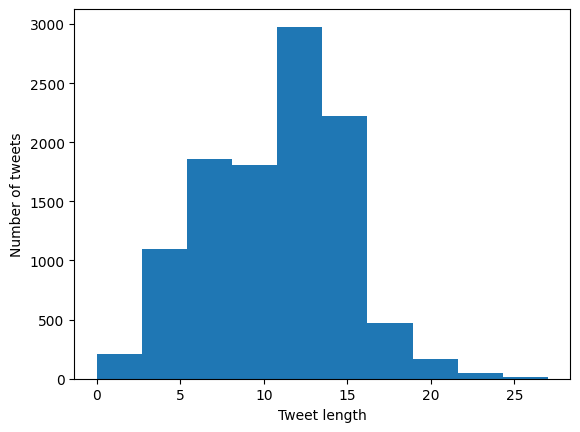

In [86]:
import matplotlib.pyplot as plt

plt.hist(tweet_length)
plt.xlabel('Tweet length')
plt.ylabel('Number of tweets')
plt.show()

## Create Embeddings

### Count Vectorizer

CountVectorizer is used because machine learning algorithms cannot work with raw text directly, so we need to convert it into numerical data. CountVectorizer is one of the simplest ways to do this, it creates a vocabulary of all the unique words in the text corpus and then counts the frequency of each word in each document. The output is a sparse matrix where each row represents a document and each column represents a word in the vocabulary, and each cell contains the count of that word in that document.

In [156]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

count_vectorizer = CountVectorizer()

# corpus = tweets['text'].tolist()
corpus = tweets['clean_text'].tolist()
labels = tweets['class_label'].tolist()

X_train, X_test, y_train, y_test = train_test_split(corpus, labels, test_size=0.2, random_state=42)

X_train_counts = count_vectorizer.fit_transform(X_train)
X_test_counts = count_vectorizer.transform(X_test)

#### Visualize count vectorizer

We can visualize the embeddings and identify any pattern present. We need to project down the embeddings to 2 dimensions as visualizing 20k dimensions is impossible, whic can be done using TruncatedSVD.

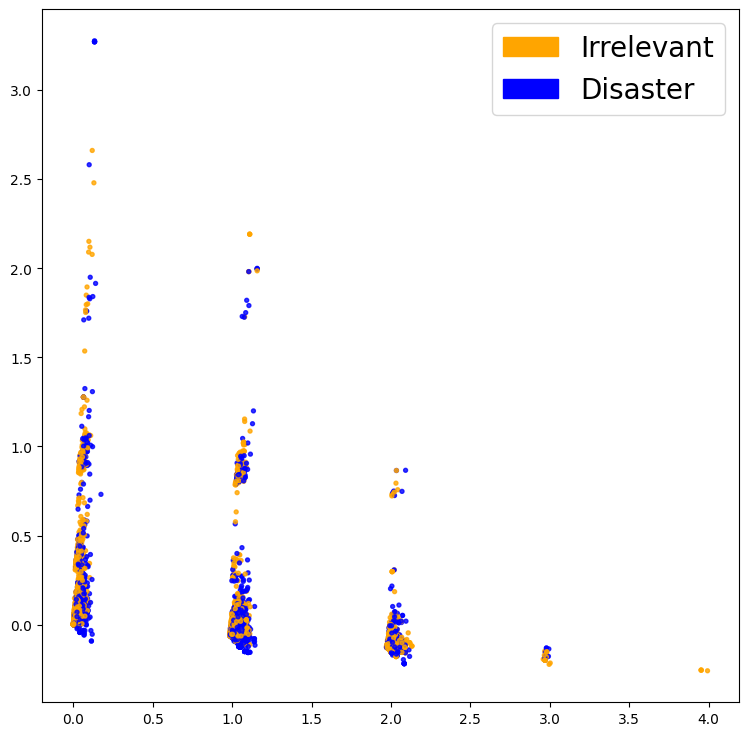

In [157]:
from sklearn.decomposition import TruncatedSVD
import matplotlib.patches as mpatches
import matplotlib

def plot_LSA(data, labels):
    lsa = TruncatedSVD(n_components=2)
    lsa.fit(data)
    lsa_scores = lsa.transform(data)
    colors = ['orange','blue','blue']
    plt.scatter(lsa_scores[:,0], lsa_scores[:,1], s=8, alpha=0.8, c=labels, cmap=matplotlib.colors.ListedColormap(colors))
    orange_patch = mpatches.Patch(color='orange', label='Irrelevant')
    blue_patch = mpatches.Patch(color='blue', label='Disaster')
    plt.legend(handles=[orange_patch, blue_patch], prop={'size': 20})

fig = plt.figure(figsize=(9,9))
plot_LSA(X_train_counts, y_train)
plt.show()

There is no clear pattern which is immediately evident.

#### Fitting a classifier

In [158]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C=30.0, class_weight='balanced', solver='newton-cg',
                         multi_class='multinomial', random_state=40)

clf.fit(X_train_counts, y_train)
y_pred_counts = clf.predict(X_test_counts)

#### Classifier evaluation

In [159]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report

def eval_metrics(Y_true, Y_pred):

    precision = precision_score(Y_true, Y_pred, pos_label=None, average='weighted')

    recall = recall_score(Y_true, Y_pred, pos_label=None, average='weighted')

    f1 = f1_score(Y_true, Y_pred, pos_label=None, average='weighted')

    accuracy = accuracy_score(Y_true, Y_pred)

    return accuracy, precision, recall, f1

accuracy, precision, recall, f1 = eval_metrics(y_test, y_pred_counts)

print(f'accuracy = {accuracy},\nprecision = {precision},\nrecall = {recall},\nf1 = {f1}')



accuracy = 0.7853860294117647,
precision = 0.7869483965016644,
recall = 0.7853860294117647,
f1 = 0.7857001542737685


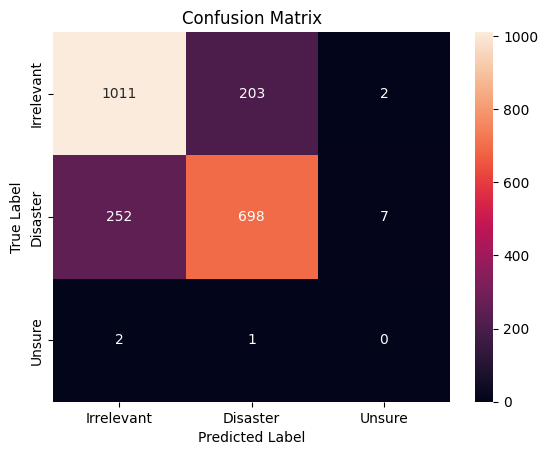

In [160]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(Y_true, Y_pred):

    cm = confusion_matrix(Y_true, Y_pred)
    tick_labels = ['Irrelevant','Disaster','Unsure']
    sns.heatmap(data=cm, annot=True, fmt='.4g', xticklabels=tick_labels, yticklabels=tick_labels)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

plot_confusion_matrix(y_test, y_pred_counts)

The classifier never correctly predicts the Unsure class, which makes sense as it is critically undersampled. The model has more false negatives than false positives. Depending on the scenario, this may be desirable as law enforecement resources are wasted in false positive cases.

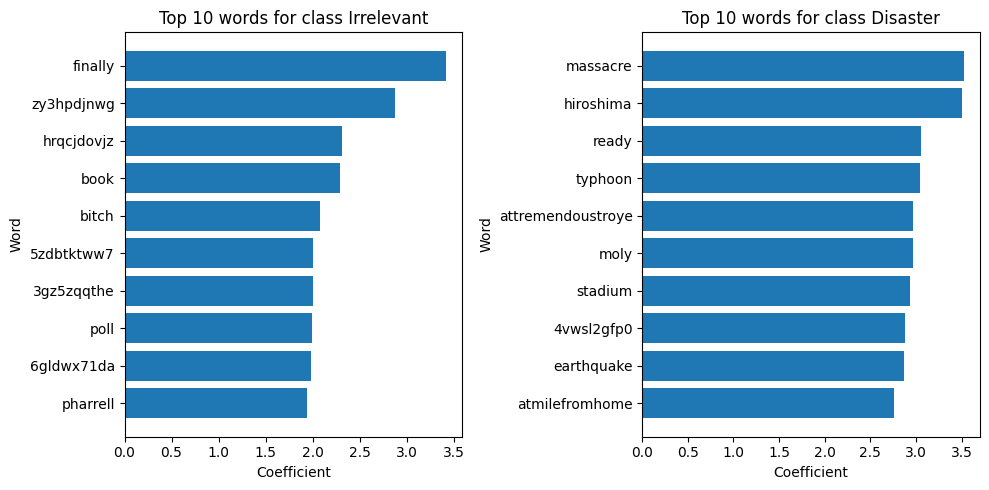

In [161]:
def plot_important_words(vectorizer, model, num_words=10):
    label = {0:'Irrelevant',1:'Disaster',2:'Unsure'}
    vocabulary = {index:word for word,index in vectorizer.vocabulary_.items()}
    # Define a list of classes to plot
    classes_to_plot = [0, 1]

    # Create subplots for each class
    fig, axes = plt.subplots(1, len(classes_to_plot), figsize=(10,5))
    # Iterate over each class
    for i, class_name in enumerate(model.classes_):
        if class_name not in classes_to_plot:
            continue
        # Extract the coefficients for the current class
        class_coefficients = model.coef_[i]
        
        # Sort the coefficients in descending order and extract the top words
        top_word_indices = class_coefficients.argsort()[::-1][:num_words]
        top_words = [vocabulary[index] for index in top_word_indices]
        top_word_coefficients = class_coefficients[top_word_indices]
        
        # Plot the top words and their coefficients
        ax = axes[classes_to_plot.index(class_name)]
        ax.barh(np.arange(len(top_words)), top_word_coefficients, align='center')
        ax.set_yticks(np.arange(len(top_words)))
        ax.set_yticklabels(top_words)
        ax.invert_yaxis()
        ax.set_xlabel('Coefficient')
        ax.set_ylabel('Word')
        ax.set_title(f'Top {len(top_words)} words for class {label[class_name]}')

plot_important_words(count_vectorizer, clf, 10)
plt.tight_layout()
plt.show()

In [34]:
clf.coef_.shape

(3, 23897)

The classifier picks up some pattern (massacre, earthquake) but overfits on irrelevant terms (sooooooo, ngkrzpza45).

### Tfidf Vectorizer

TFIDF (Term Frequency, Inverse Document Frequency) helps us identify words that are important in a document by giving us a score that reflects how frequently they appear in that document and how rare they are across all documents.

In [162]:
tfidf_vectorizer = TfidfVectorizer()

X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

#### Visualize Tfidf vectorizer

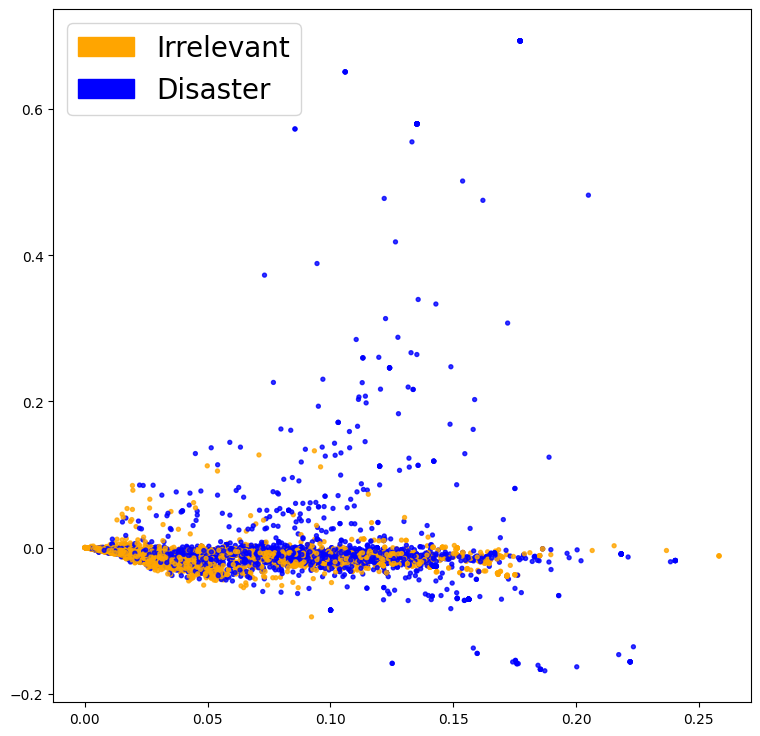

In [163]:
fig = plt.figure(figsize=(9,9))
plot_LSA(X_train_tfidf, y_train)
plt.show()

These embeddings are much more separated than the count vectorizer embeddings

#### Fitting a classifier

In [164]:
clf_tfid = LogisticRegression(C=30.0, class_weight='balanced', solver='newton-cg', 
                         multi_class='multinomial', random_state=42)

clf_tfid.fit(X_train_tfidf, y_train)
y_pred_tfidf = clf_tfid.predict(X_test_tfidf)

#### Evaluating classifier

In [165]:
accuracy_tfidf, precision_tfidf, recall_tfidf, f1_tfidf = eval_metrics(y_test, y_pred_tfidf)
print(f'accuracy = {accuracy_tfidf},\nprecision = {precision_tfidf},\nrecall = {recall_tfidf},\nf1 = {f1_tfidf}')

accuracy = 0.7863051470588235,
precision = 0.7852610868566177,
recall = 0.7863051470588235,
f1 = 0.7857823000092055


d:\Portfolio\Tweet Classification\venv\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


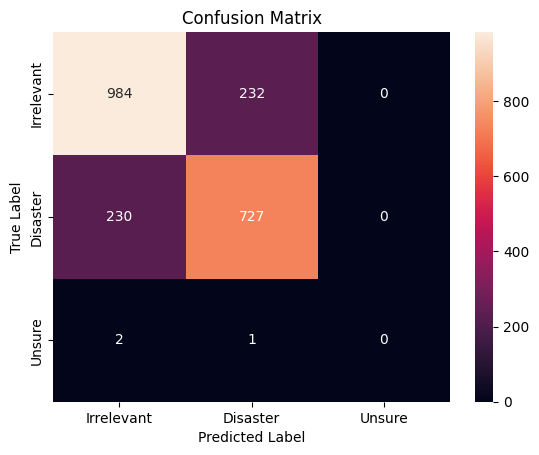

In [166]:
plot_confusion_matrix(y_test, y_pred_tfidf)

There is an evident decrease in false positives as the model is more conservative in predicting the positive class.

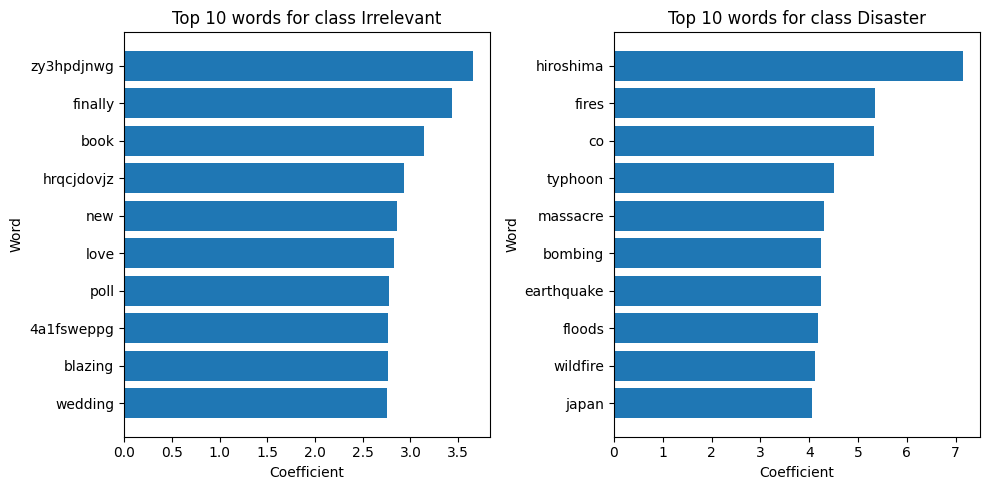

In [167]:
plot_important_words(tfidf_vectorizer, clf_tfid)
plt.tight_layout()
plt.show()

Although the evaluation metrics are not much better, the model is picking much more relevant terms and thus the predictions can be made more confidently.

### Capture semantics with word2vec

Our initial models have been able to identify direct words like typhoon, earthquake, wildfire etc. However, it is unlikely that the training set will contain all the direct words. To that end, we need to capture the semantic meaning of words. We need the classification model to understand that words like 'bad' and 'negative' are semantically closer than 'food' and 'transport'.

Word2vec is a pre-trained model that provides embeddings that map similar words close to each other. A quick way to obtain a sentence embedding is to average word2vec scores of all words in a sentence.

In [107]:
import gensim

word2vec_path = "./GoogleNews-vectors-negative300.bin.gz"
word2vec = gensim.models.KeyedVectors.load_word2vec_format(word2vec_path, binary=True)

In [168]:
def get_average_word2vec(tokens_list, vector, k=300):
    # k = 300 because word2vec['word'] is an array of shape (300,)
    if len(tokens_list)<1:
        return np.zeros(k)
    else:
        vectorized = [vector[word] if word in vector else np.zeros(k) for word in tokens_list]
    length = len(vectorized)
    summed = np.sum(vectorized, axis=0)
    averaged = np.divide(summed, length)
    return averaged

def get_word2vec_embeddings(vectors, df, col):
    embeddings = df[col].apply(lambda x: get_average_word2vec(x, vectors))
    return list(embeddings)

In [169]:
embeddings = get_word2vec_embeddings(word2vec, tweets, 'clean_tokens')
X_train_word2vec, X_test_word2vec, y_train_word2vec, y_test_word2vec = train_test_split(embeddings, labels, 
                                                                                        test_size=0.2, random_state=40)

#### Visualize word2vec

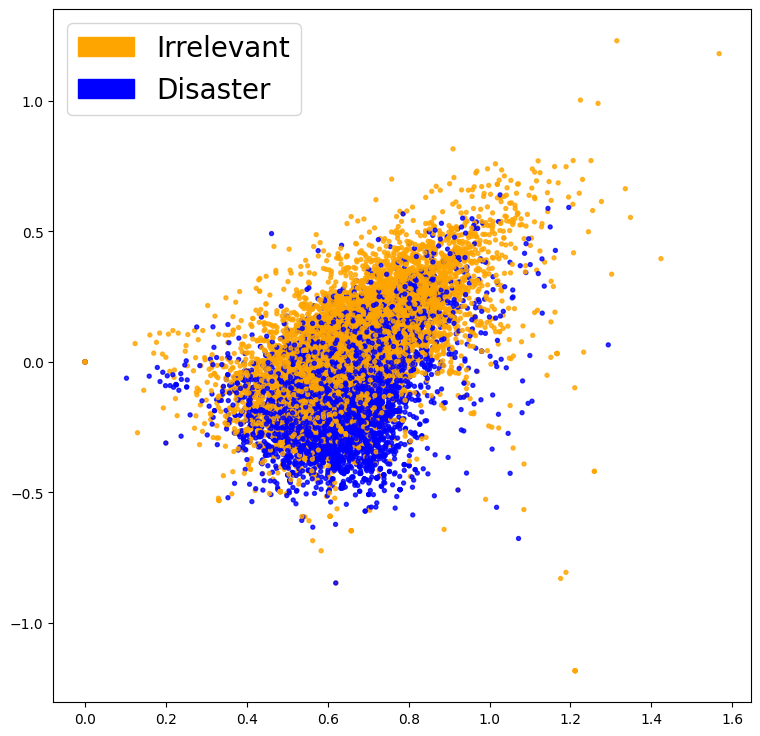

In [170]:
fig = plt.figure(figsize=(9,9))
plot_LSA(embeddings, labels)
plt.show()

These embeddings much more separated than before.

#### Fitting a classifier

In [171]:
clf_w2v = LogisticRegression(C=30.0, class_weight='balanced', solver='newton-cg', 
                             multi_class='multinomial', random_state=40)
clf_w2v.fit(X_train_word2vec, y_train_word2vec)
y_pred_word2vec = clf_w2v.predict(X_test_word2vec)

#### Evaluating classifier

In [172]:
accuracy_word2vec, precision_word2vec, recall_word2vec, f1_word2vec = eval_metrics(y_test_word2vec, y_pred_word2vec)
print(f'accuracy = {accuracy_word2vec},\nprecision = {precision_word2vec},\nrecall = {recall_word2vec},\nf1 = {f1_word2vec}')

accuracy = 0.7706801470588235,
precision = 0.7717792822880105,
recall = 0.7706801470588235,
f1 = 0.7708669912472018


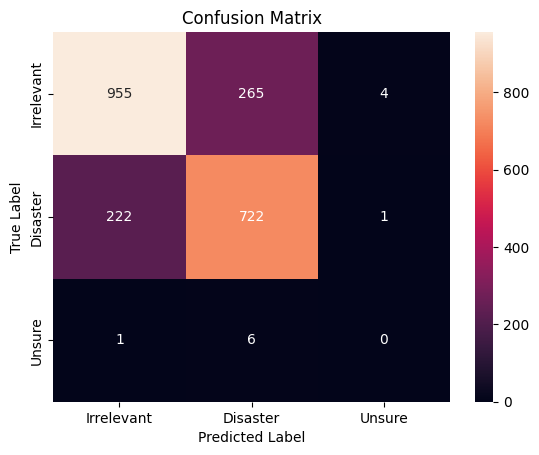

In [173]:
plot_confusion_matrix(y_test_word2vec, y_pred_word2vec)

In [174]:
from sklearn.ensemble import RandomForestClassifier

clf_rf = RandomForestClassifier(class_weight='balanced')
clf_rf.fit(X_train_word2vec, y_train_word2vec)
y_pred_Rf = clf_rf.predict(X_test_word2vec)

In [175]:
accuracy_rf, precision_rf, recall_rf, f1_rf = eval_metrics(y_test_word2vec, y_pred_Rf)
print(f'accuracy = {accuracy_rf},\nprecision = {precision_rf},\nrecall = {recall_rf},\nf1 = {f1_rf}')

accuracy = 0.7826286764705882,
precision = 0.7855716923374307,
recall = 0.7826286764705882,
f1 = 0.7765849030783414


d:\Portfolio\Tweet Classification\venv\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


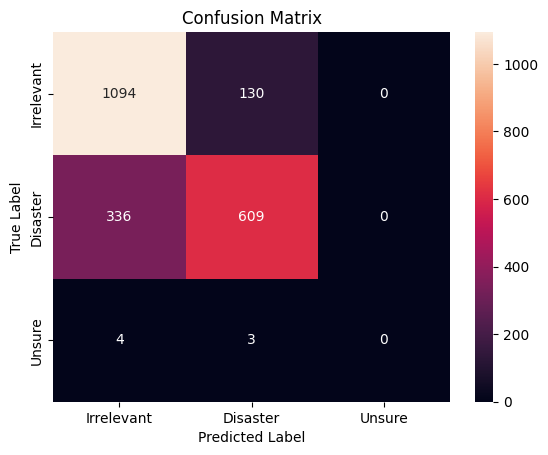

In [176]:
plot_confusion_matrix(y_test_word2vec, y_pred_Rf)

In [200]:
from sklearn import svm

clf_svm = svm.SVC(C=30, class_weight='balanced')
clf_svm.fit(X_train_word2vec, y_train_word2vec)
y_pred_svm = clf_svm.predict(X_test_word2vec)

In [201]:
accuracy_svm, precision_svm, recall_svm, f1_svm = eval_metrics(y_test_word2vec, y_pred_svm)
print(f'accuracy = {accuracy_svm},\nprecision = {precision_svm},\nrecall = {recall_svm},\nf1 = {f1_svm}')

accuracy = 0.78125,
precision = 0.7780168056765194,
recall = 0.78125,
f1 = 0.7792106277794145


d:\Portfolio\Tweet Classification\venv\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


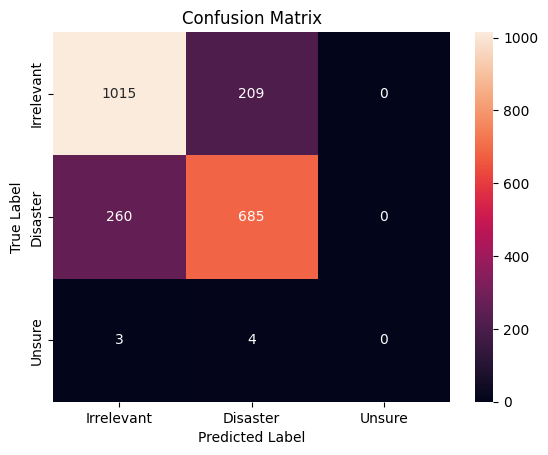

In [202]:
plot_confusion_matrix(y_test_word2vec, y_pred_svm)

In [49]:
tweets.head()

,text,choose_one,class_label,tokens
0,just happened a terrible car crash,Relevant,1,"[just, happened, a, terrible, car, crash]"
1,our deeds are the reason of this #earthquake m...,Relevant,1,"[our, deeds, are, the, reason, of, this, earth..."
2,"heard about #earthquake is different cities, s...",Relevant,1,"[heard, about, earthquake, is, different, citi..."
3,"there is a forest fire at spot pond, geese are...",Relevant,1,"[there, is, a, forest, fire, at, spot, pond, g..."
4,forest fire near la ronge sask. canada,Relevant,1,"[forest, fire, near, la, ronge, sask, canada]"


In [192]:
from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical, pad_sequences

EMBEDDING_DIM = 300
MAX_SEQUENCE_LENGTH = 35
VOCAB_SIZE = len(vocab_clean)

VALIDATION_SPLIT=.2
tokenizer = Tokenizer(num_words=VOCAB_SIZE)
tokenizer.fit_on_texts(tweets["clean_text"].tolist())
sequences = tokenizer.texts_to_sequences(tweets["clean_text"].tolist())

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

cnn_data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
labels = to_categorical(np.asarray(tweets["class_label"]))

indices = np.arange(cnn_data.shape[0])
np.random.shuffle(indices)
cnn_data = cnn_data[indices]
labels = labels[indices]
num_validation_samples = int(VALIDATION_SPLIT * cnn_data.shape[0])

embedding_weights = np.zeros((len(word_index)+1, EMBEDDING_DIM))
for word,index in word_index.items():
    embedding_weights[index,:] = word2vec[word] if word in word2vec else np.random.rand(EMBEDDING_DIM)
print(embedding_weights.shape)

Found 28062 unique tokens.
(28063, 300)


In [193]:
from keras.layers import Input, Flatten,Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout, Concatenate
from keras.models import Model
from keras.utils import plot_model

# set parameters for the model
embedding_dim = 300
num_filters = 128
filter_sizes = [3, 4, 5]
dropout_rate = 0.5
max_seq_length = MAX_SEQUENCE_LENGTH
vocab_size = len(word_index)+1
num_classes = tweets.class_label.nunique()
# define the input layer
input_layer = Input(shape=(max_seq_length,), dtype='int32')

# add an embedding layer
embedding_layer = Embedding(vocab_size, embedding_dim, 
                            input_length=max_seq_length,
                            weights = [embedding_weights],
                            trainable=False)(input_layer)

# add multiple convolutional layers with different filter sizes
conv_layers = []
for filter_size in filter_sizes:
    conv_layer = Conv1D(num_filters, filter_size, activation='relu')(embedding_layer)
    pool_layer = GlobalMaxPooling1D()(conv_layer)
    conv_layers.append(pool_layer)

# concatenate the output of the convolutional layers
concat_layer = Concatenate()(conv_layers)

# add a dropout layer
dropout_layer = Dropout(dropout_rate)(concat_layer)
flatten_layer = Flatten()(dropout_layer)
# add a dense output layer
penul_layer = Dense(128, activation='relu')(flatten_layer)
output_layer = Dense(num_classes, activation='softmax')(penul_layer)
# create the model
model = Model(inputs=input_layer, outputs=output_layer)

# compile the model
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# print the model summary
model.summary()

# plot the model architecture
plot_model(model, show_shapes=True)


Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 35)]         0           []                               
                                                                                                  
 embedding_7 (Embedding)        (None, 35, 300)      8418900     ['input_8[0][0]']                
                                                                                                  
 conv1d_19 (Conv1D)             (None, 33, 128)      115328      ['embedding_7[0][0]']            
                                                                                                  
 conv1d_20 (Conv1D)             (None, 32, 128)      153728      ['embedding_7[0][0]']            
                                                                                            

In [194]:
x_train = cnn_data[:-num_validation_samples]
y_train = labels[:-num_validation_samples]
x_val = cnn_data[-num_validation_samples:]
y_val = labels[-num_validation_samples:]

In [195]:
model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=3, batch_size=64)


Epoch 1/3
136/136 [==============================] - 15s 99ms/step - loss: 0.5873 - accuracy: 0.7111 - val_loss: 0.4684 - val_accuracy: 0.7908
Epoch 2/3
136/136 [==============================] - 16s 118ms/step - loss: 0.4445 - accuracy: 0.7997 - val_loss: 0.4744 - val_accuracy: 0.7738
Epoch 3/3
136/136 [==============================] - 22s 161ms/step - loss: 0.4020 - accuracy: 0.8251 - val_loss: 0.4608 - val_accuracy: 0.7954


In [196]:
y_cnn_pred = model.predict(x_val)   
predicted_classes = np.argmax(y_cnn_pred, axis=1)
predicted_classes                                                                                   

68/68 [==============================] - 1s 13ms/step


array([1, 1, 0, ..., 0, 0, 1], dtype=int64)

In [72]:
y_val

array([[1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       ...,
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 1., 0.]], dtype=float32)

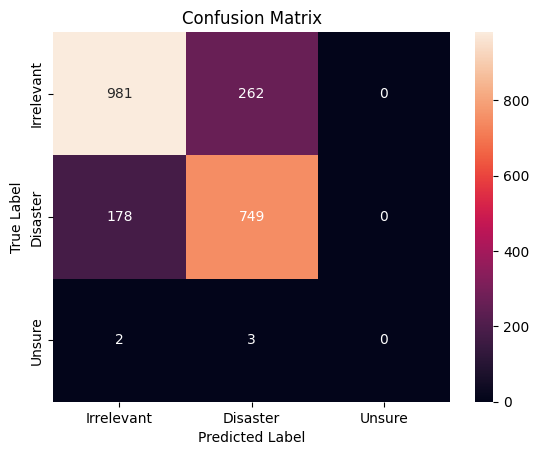

In [197]:
plot_confusion_matrix(np.argmax(y_val, axis=1), np.argmax(y_cnn_pred, axis=1))

In [198]:
accuracy_cnn, precision_cnn, recall_cnn, f1_cnn = eval_metrics(np.argmax(y_val, axis=1), np.argmax(y_cnn_pred, axis=1))
print(f'accuracy = {accuracy_cnn},\nprecision = {precision_cnn},\nrecall = {recall_cnn},\nf1 = {f1_cnn}')

accuracy = 0.7954022988505747,
precision = 0.7977119577452684,
recall = 0.7954022988505747,
f1 = 0.7953516598984991


d:\Portfolio\Tweet Classification\venv\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
